### This notebook is used to generate visualisation of images in this hives

In [1]:
# Bunch of imports
import pandas as pd
import sys, os, cv2
from datetime import datetime, timezone
import matplotlib.pyplot as plt
sys.path.append('Preprocessing')
sys.path.append('ForegroundRemoval/MedianFilter')
sys.path.append('ForegroundRemoval/PercentileFilter')
sys.path.append('VideoManagment')
from Preprocessing.preproc import beautify_frame
from VideoManagment.videolib import imageHiveOverview
from libimage import fetchImagesPaths
from ForegroundRemoval.PercentileFilter.percentile import percentile_filter_df

# Ignore FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Configuration

In [2]:
# Get the latest picture of the hive specified. Last common picture taken by all cameras
hive = 1
data_folder = "/Users/cyrilmonette/Library/CloudStorage/SynologyDrive-data/25.07_aSensing_OH/Images/"
use_latest = True  # If True, use the latest picture, otherwise use the date specified below
remove_bees = True  # If True, remove bees from the image
if not use_latest:
    dt = pd.Timestamp("2024-10-28 10:50:00").tz_localize('UTC')

validity_recovery_time = 120  # Time in minutes to consider a hive valid after it has been opened

## Main script

Latest common image time: 2025-08-25 12:15:02+00:00


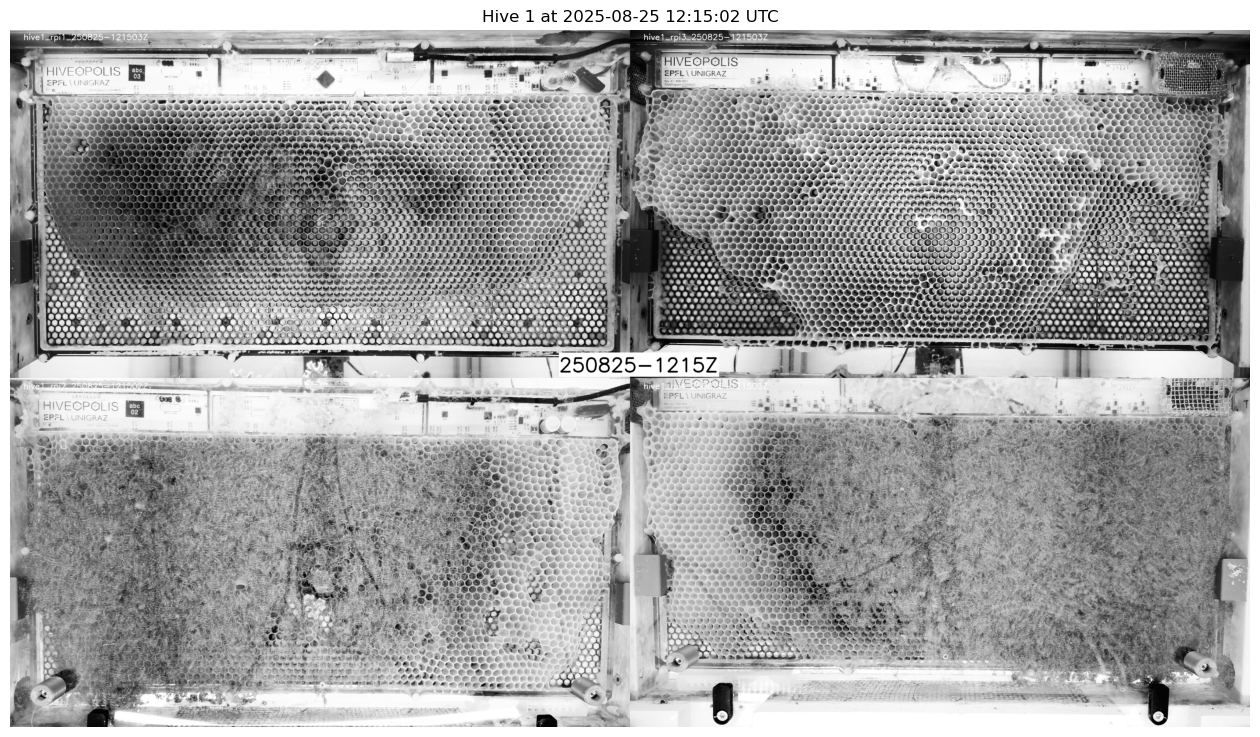

In [3]:
# Within the subfolders, find those that have the hive number
subfolders = [f for f in os.listdir(data_folder) if "h"+str(hive)+"r" in f]
subfolders.sort()

if use_latest:
    # Within those subfolders, find the last image taken commom to all cameras based on filename
    # Initialize a dictionary to store the latest image time for each subfolder
    latest_images = {}
    for subfolder in subfolders:
        files = [f for f in os.listdir(data_folder + subfolder) if f.endswith('.jpg')]
        for file in files:
            time = str(file.split('_')[-1].split('.')[0])
            aware_dt = pd.to_datetime(time, format='%y%m%d-%H%M%SZ').tz_localize('UTC')
            if subfolder not in latest_images or aware_dt > latest_images[subfolder]:
                latest_images[subfolder] = aware_dt

    # Find the latest common image time
    latest_common_time = min(latest_images.values())
    print("Latest common image time:", latest_common_time)
    timestamp = latest_common_time

else:
    # Use the specified date
    timestamp = dt

imgs_paths = fetchImagesPaths(data_folder, [timestamp], str(hive), invalid_recovery_time=validity_recovery_time)
row = imgs_paths.iloc[0].copy()
validity = row.loc['valid'] 
row.drop('valid', inplace=True)

# Raise an error if row contains None values
if row.isnull().any():
    raise ValueError("Some or all images are missing for the specified timestamp.")

if remove_bees:
    row = pd.DataFrame(row).T # This converts the row to a DataFrame with a single row
    images, names = percentile_filter_df(row, percentile=90, filter_length=20, frame_skip=5, annotate_names=False, verbose=False)
    composed_img = imageHiveOverview(images.iloc[0].to_list(), names.iloc[0].to_list(), dt=timestamp, valid=validity)

else:
    # Read images with cv2.imread from images paths and store in a list
    images = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in row.tolist()]
    images = [beautify_frame(image) for image in images]
    imgs_names = [f.split('/')[-1] for f in row.tolist()]
    imgs_names = [name.replace('.jpg', '') for name in imgs_names]
    composed_img = imageHiveOverview(images, imgs_names, dt=timestamp, valid=validity)

plt.figure(figsize=(16,12))
# Display the composed image in rgb format
plt.imshow(cv2.cvtColor(composed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Hive " + str(hive) + " at " + timestamp.tz_convert('UTC').strftime("%Y-%m-%d %H:%M:%S") + " UTC")
plt.show()